In [13]:
from dataset import load_all_stock_data
import pandas as pd
from dataset import ConditionalStockDataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from multi_stock_input_modules import ResidualMLPWithExtraBlock as ResidualMLP
from multi_stock_input_modules import forward_diffusion_sample
from multi_stock_input_modules import reverse_diffusion_sample
import torch.nn.functional as F
from multi_stock_input_modules import Context_Encoder
from multi_stock_input_modules import cosine_beta_schedule
from multi_stock_input_modules import get_time_embedding
from multi_stock_input_modules import TickerEmbedding
import torch

In [14]:
#Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Data Loading

In [15]:
data_path = "../price/raw/"
data = load_all_stock_data(data_path)

Loaded and processed data for 88 stocks


In [16]:
# Quick sanity test
li = [1,3,4,6,7,8,9,10,11,12]
context_len_test = 4
for i in range(0,len(li)-context_len_test):
    testing = li[i:i+context_len_test]
    testing2 = li[i+context_len_test -1]
    print(testing, testing2)


[1, 3, 4, 6] 6
[3, 4, 6, 7] 7
[4, 6, 7, 8] 8
[6, 7, 8, 9] 9
[7, 8, 9, 10] 10
[8, 9, 10, 11] 11


In [17]:
context_len = 10
feature_columns = ["Open","High","Low","Volume","Return","Overnight_Return","TR","Vol_5d","Vol_10d","Return_Z","Diff","HL_Diff","MA5","Return_MA5"]
target_column = ["Return","Overnight_Return","TR","Return_Z"]
train_data = ConditionalStockDataset(data,context_len,feature_columns,target_column,split='train',normalization="standard",device=device)
test_data = ConditionalStockDataset(data,context_len,feature_columns,target_column,split='test',normalization="standard",device=device)

In [18]:
for ticker,context,target in train_data :
    print(ticker,context,target)
    break

BA tensor([[-2.0032, -1.9992, -1.9807, -0.1174,  0.1274,  0.4626, -0.2144,  0.0205,
         -0.3028,  0.3632,  0.0408, -1.0168, -2.0114, -0.0713],
        [-1.9952, -2.0109, -1.9999, -0.4805, -0.8468,  0.1525, -0.1822, -0.2656,
         -0.3192, -0.7901, -0.4759, -0.8249, -2.0115, -0.3188],
        [-2.0019, -2.0204, -1.9948, -0.4694, -0.1269,  0.6758, -0.8006, -1.1653,
         -0.5518,  0.1079, -0.0937, -1.2087, -2.0105, -0.1324],
        [-1.9911, -2.0084, -1.9833, -0.5814, -0.4727,  0.6917, -0.7775, -1.1650,
         -0.6382, -0.2565, -0.2777, -1.1921, -2.0131, -0.6788],
        [-1.9904, -1.9808, -1.9676, -0.2225,  0.7650,  0.5755,  0.1046, -0.6129,
         -0.4707,  1.1773,  0.3806, -0.8750, -2.0141, -0.6792],
        [-1.9758, -1.9827, -1.9567, -0.5734, -0.2717, -0.3619, -0.8173, -0.6422,
         -0.6135, -0.1528, -0.1715, -1.2087, -2.0058, -0.2356],
        [-1.9764, -1.9821, -1.9628, -0.0767, -0.1527,  0.2081, -0.5307, -0.9185,
         -0.9444,  0.0136, -0.1078, -1.0335, -

In [19]:
print(len(train_data),len(test_data))

84765 21215


In [20]:
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
test_laoder = DataLoader(test_data, batch_size =16, shuffle = False)

In [21]:
for sample in train_loader :
    print(f" Shape of context: {sample[1].shape} \n Shape of x0: {sample[2].shape}")
    break

 Shape of context: torch.Size([16, 10, 14]) 
 Shape of x0: torch.Size([16, 4])


In [22]:
# Hyperparameters
num_diffusion_steps = 100  # Total diffusion steps
num_epochs = 50
batch_size = 16
learning_rate = 1e-4

# Create a beta schedule: linearly spaced between 0.0001 and 0.01
# betas = torch.linspace(0.0001, 0.01, num_diffusion_steps)
betas = cosine_beta_schedule(num_diffusion_steps, s=0.008).to(device)


# Since our targets are scalars, dim = 1
dim = 4
embedding_dim = 32  # As used in get_time_embedding
#hidden_size for context = context_embedding size
context_embedding_size = 32
ticker_embedding_dim = 32

# Denoise net parameters : dim, embedding_dim, context_embedding_size, hidden_size=512, num_chunks=8, attn_heads=4, dropout_prob=0.1

denoise_net = ResidualMLP(dim=4, embedding_dim=32, context_embedding_size=32, ticker_embedding_size=ticker_embedding_dim, hidden_size=512, num_chunks=8, attn_heads=4,dropout_prob=0.1).to(device)

#input size = num of features

input_size = 9
context_input_dim = 14
context_hidden_dim = 32


# Context encoding parameters : input_dim, hidden_dim, kernel_size=3, dilation_rates=[1, 2, 4], num_heads=4
context_net = Context_Encoder(input_dim=context_input_dim, hidden_dim=context_hidden_dim, kernel_size=3, dilation_rates=[1,2,4], num_heads=4).to(device)
# Define the optimizer
optimizer = torch.optim.Adam(denoise_net.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# To generate the ticker embeddings, we need to get a list of all the inique tickers in the dataset

ticker_list =[tickers for tickers,_,_ in train_data]
unique_tickers = [ticker for ticker in set(ticker_list)]


ticker_emb_layer = TickerEmbedding(ticker_list = unique_tickers, ticker_embedding_dim=32).to(device)


for epoch in range(num_epochs):
    all_losses = []
    for ticker,context,x0 in train_loader:
        denoise_net.train()
        context_net.train()
        ticker_emb_layer.train()

        # Again, ticker is name of stock
        # Context is a tensor of [batch_size, context_len=10, feature_dim=9]
        # x0 is a tensor of [batch_size,dim=1]

        # Ensure x0 is shaped as [batch_size, dim]
        # context is of shape [batch_size, context_len, num_features]
        
        # Sample a random diffusion timestep for each sample in the batch
        batch_size = x0.shape[0]
        t = torch.randint(0, num_diffusion_steps, (batch_size,), dtype=torch.long,device=device)
        
        # Generate the noisy sample and the true noise using forward diffusion
        x_t, true_noise = forward_diffusion_sample(x0, t, betas)
        # print(f"x_t shape : {x_t.shape}")
        
        # Compute time embedding for the sampled timesteps
        time_embedding = get_time_embedding(t, embedding_dim)
        # print(f"time_embedding shape : {time_embedding.shape}")
        
        # Concatenate x_t with the time embedding to form the input to the denoising network
        x_combined = torch.cat([x_t, time_embedding], dim=-1)
        # x_combined shape is [batch_size, dim + embedding_dim]
        # print(f"x_combined shape : {x_combined.shape}")
        
        # Get context embedding
        context_embedding = context_net(context)
        # print(f"context_embedding shape :{context_embedding.shape}")

        x_combined = torch.cat([x_combined, context_embedding], dim=-1)
        # print(f"x_combined shape : {x_combined.shape}")

        ticker_emb = ticker_emb_layer(ticker) # Should be shape [num_tickers (should be batch_size),embedding_dim]
        # print(f"ticker embedding shape : {ticker_emb.shape}")

        x_combined = torch.cat([x_combined, ticker_emb], dim = -1)
        # print(f"x_combined after ticker emb : {x_combined.shape}")
        
        # Predict the noise using the denoising network directly
        predicted_noise = denoise_net(x_combined)
        
        # Compute the loss between predicted noise and true noise
        loss = F.mse_loss(predicted_noise, true_noise)
        all_losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(denoise_net.parameters(), max_norm=1.0)
        optimizer.step()
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}, Loss: {sum(all_losses)/len(all_losses)}, LR: {current_lr} ")

KeyboardInterrupt: 

In [16]:
import torch
import torch.nn.functional as F

# Set the models to evaluation mode
denoise_net.eval()
context_net.eval()
ticker_emb_layer.eval()

all_losses = []
all_predictions = []
all_ground_truths = []

with torch.no_grad():
    for tickers, context, x0 in test_laoder:
        # Move context and x0 to device; tickers remain as a list of strings
        context = context
        x0 = x0
        batch_size = x0.shape[0]

        # Initialize x_T as pure Gaussian noise (on device)
        x_T = torch.randn(batch_size, dim, device=device)
        x_t = x_T

        # Run the reverse diffusion chain
        for t_val in reversed(range(num_diffusion_steps)):
            # Create a timestep tensor on device
            t_tensor = torch.full((batch_size,), t_val, dtype=torch.long,device=device)
            
            # Compute time embedding
            time_embedding = get_time_embedding(t_tensor, embedding_dim)  # [batch_size, embedding_dim]
            
            # Get context embedding from the context encoder
            context_embedding = context_net(context)  # [batch_size, context_embedding_size]
            
            # Get ticker embeddings from the ticker embedding layer.
            # (ticker is a list of ticker strings; ticker_emb_layer converts them to a tensor of shape [batch_size, ticker_embedding_dim])
            ticker_embedding = ticker_emb_layer(tickers)  # [batch_size, ticker_embedding_dim]
            
            # Concatenate x_t, time embedding, context embedding, and ticker embedding.
            # x_t: [batch_size, dim]
            # time_embedding: [batch_size, embedding_dim]
            # context_embedding: [batch_size, context_embedding_size]
            # ticker_embedding: [batch_size, ticker_embedding_dim]
            x_combined = torch.cat([x_t, time_embedding, context_embedding, ticker_embedding], dim=-1)
            # x_combined shape: [batch_size, total_input_dim] where total_input_dim = dim + embedding_dim + context_embedding_size + ticker_embedding_dim

            # Predict the noise using the denoising network
            predicted_noise = denoise_net(x_combined)  # [batch_size, dim]

            # Retrieve beta_t for the current timestep (ensure betas is on device)
            beta_t = betas[t_tensor].unsqueeze(1)  # [batch_size, 1]
            alpha_t = 1 - beta_t  # [batch_size, 1]
            alphas = 1 - betas  # [num_diffusion_steps]
            alpha_bars = torch.cumprod(alphas, dim=0)  # [num_diffusion_steps]
            alpha_bar_t = alpha_bars[t_tensor].unsqueeze(1)  # [batch_size, 1]
            sqrt_alpha_t = torch.sqrt(alpha_t)  # [batch_size, 1]
            sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)  # [batch_size, 1]

            # Reverse diffusion update: x_{t-1} = ( x_t - (beta_t/sqrt(1 - alpha_bar_t)) * predicted_noise ) / sqrt(alpha_t)
            x_t = (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * predicted_noise) / sqrt_alpha_t

        # After the reverse chain, x_t is the predicted clean sample x0_pred
        x0_pred = x_t

        # Compute MSE loss between predicted x0 and true x0
        loss = F.mse_loss(x0_pred, x0)
        all_losses.append(loss.item())

        # Collect predictions and ground truths for later analysis
        all_predictions.append(x0_pred.cpu())
        all_ground_truths.append(x0.cpu())

average_loss = sum(all_losses) / len(all_losses)
print("Average Test MSE:", average_loss)

# Optionally, inspect a few batches:
for i in range(min(10, len(all_predictions))):
    print(f"Batch {i+1} predictions:\n", all_predictions[i])
    print(f"Batch {i+1} ground truth:\n", all_ground_truths[i])


Average Test MSE: 91.8823464737036
Batch 1 predictions:
 tensor([[0.0010],
        [0.0010],
        [0.0010],
        [0.0010],
        [0.0010],
        [0.0010],
        [0.0009],
        [0.0009],
        [0.0009],
        [0.0009],
        [0.0009],
        [0.0009],
        [0.0009],
        [0.0009],
        [0.0009],
        [0.0009]])
Batch 1 ground truth:
 tensor([[0.0006],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0005],
        [0.0005],
        [0.0005],
        [0.0005],
        [0.0005],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0006],
        [0.0006]])
Batch 2 predictions:
 tensor([[ 8.9464e-04],
        [ 8.8782e-04],
        [ 8.8275e-04],
        [-2.7676e+02],
        [ 8.7944e-04],
        [ 8.8753e-04],
        [ 8.8943e-04],
        [ 8.9406e-04],
        [ 8.9648e-04],
        [ 8.9918e-04],
        [ 9.0120e-04],
        [ 9.0154e-04],
        [ 9.0624e-04],
        [ 9.1357e-04]

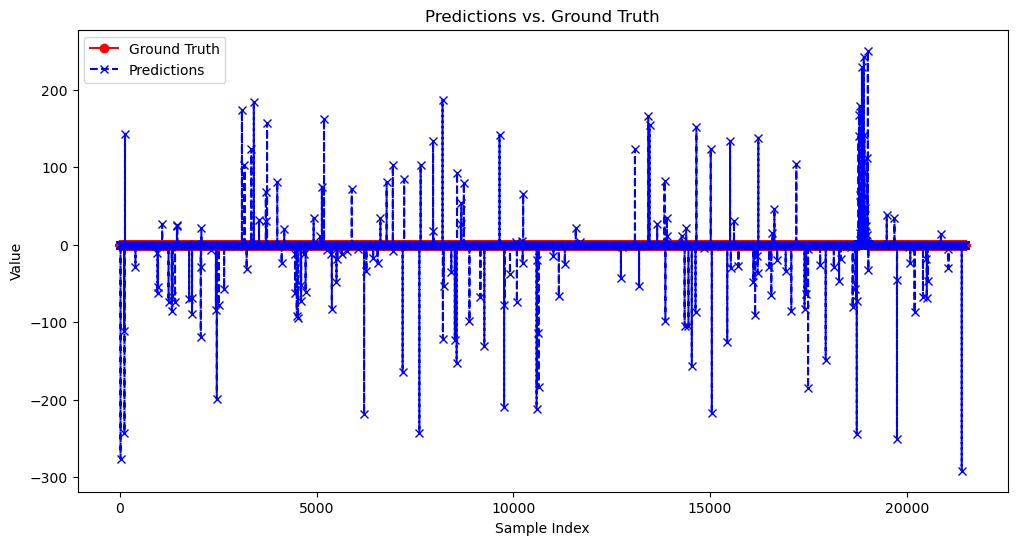

In [17]:
import matplotlib.pyplot as plt
import torch

# Concatenate all batch predictions and ground truths along the batch dimension
pred_array = torch.cat(all_predictions, dim=0).cpu().numpy().flatten()

true_array = torch.cat(all_ground_truths, dim=0).cpu().numpy().flatten()

plt.figure(figsize=(12, 6))
plt.plot(true_array, label='Ground Truth', marker='o', linestyle='-', color='red')
plt.plot(pred_array, label='Predictions', marker='x', linestyle='--', color='blue')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Predictions vs. Ground Truth')
plt.legend()
plt.show()
